[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/w

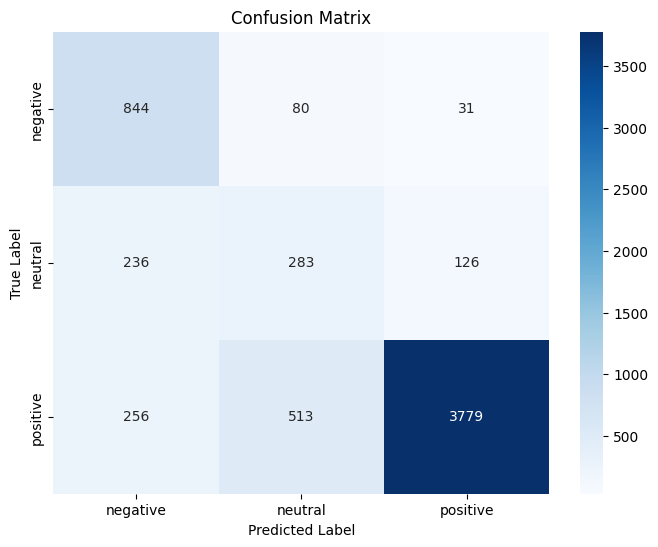

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from gensim.models import KeyedVectors
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import normalize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data_path = '/kaggle/input/trip-advisor-hotel-reviews/tripadvisor_hotel_reviews.csv'
data = pd.read_csv(data_path)

# Preprocessing: Text Cleaning, Tokenization, and Normalization
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I | re.A)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.lower()

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = clean_text(text)
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

data['Cleaned_Review'] = data['Review'].apply(preprocess_text)

# Create sentiment labels from ratings
def rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['Sentiment'] = data['Rating'].apply(rating_to_sentiment)

# Convert 'Sentiment' column to category
data['Sentiment'] = data['Sentiment'].astype('category')

# Load FastText model
fasttext_model_path = '/kaggle/input/fasttext-wikinews/wiki-news-300d-1M.vec'
fasttext_vectors = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=False)

# Convert text data to FastText vectors (average of word vectors)
def text_to_vector(text):
    tokens = nltk.word_tokenize(text.lower())
    vectors = [fasttext_vectors[word] for word in tokens if word in fasttext_vectors]
    return np.mean(vectors, axis=0) if vectors else np.zeros(300)

vectors = np.array([text_to_vector(text) for text in data['Cleaned_Review']])

# Normalize vectors
vectors = normalize(vectors, axis=1)

# Split data into train and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(vectors, data['Sentiment'], test_size=0.3, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.cat.codes.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.cat.codes.values, dtype=torch.long).to(device)

# Define BiLSTM model
class SentimentBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout=0.3):
        super(SentimentBiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # hidden_size * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add dimension for seq_length
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)  # * 2 for bidirectional
        bilstm_out, _ = self.bilstm(x, (h0, c0))
        bilstm_out = self.dropout(bilstm_out)
        bilstm_out = bilstm_out[:, -1, :]
        output = self.fc(bilstm_out)
        return output

# Define parameters
input_size = 300  # Size of FastText word vectors
hidden_size = 128
output_size = len(data['Sentiment'].unique())

# Calculate class weights
class_counts = Counter(y_train)
total_samples = len(y_train)
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor([class_weights[cls] for cls in sorted(class_counts.keys())], dtype=torch.float32).to(device)

# Create BiLSTM model instance
bilstm_model = SentimentBiLSTM(input_size, hidden_size, output_size, num_layers=2, dropout=0.3).to(device)

# Define optimizer and loss function
optimizer = optim.Adam(bilstm_model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Define DataLoader
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Training loop
def train_model(model, train_loader, optimizer, loss_fn, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
    return model

# Train the model
trained_model = train_model(bilstm_model, train_loader, optimizer, loss_fn, num_epochs=20)

# Final evaluation on test set
def final_evaluation(model, test_vectors_tensor, test_labels_tensor):
    model.eval()
    with torch.no_grad():
        outputs = model(test_vectors_tensor)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == test_labels_tensor).sum().item() / len(test_labels_tensor)
        cm = confusion_matrix(test_labels_tensor.cpu(), predicted.cpu())
        cr = classification_report(test_labels_tensor.cpu(), predicted.cpu(), target_names=['negative', 'neutral', 'positive'])
    return acc, cm, cr

# Evaluate the model on the test set
final_acc, final_cm, final_cr = final_evaluation(trained_model, X_test_tensor, y_test_tensor)
print(f"Test Accuracy: {final_acc:.4f}")
print("Confusion Matrix:")
print(final_cm)
print("\nClassification Report:")
print(final_cr)

# Confusion Matrix Visualization
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(final_cm, ['negative', 'neutral', 'positive'])
